---
title: Interactive Phase Correction Widget
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 150

While automated phasing algorithms (like ACME) are incredibly powerful, heavily distorted baselines, massive solvent peaks, or extreme noise can sometimes trick the optimizer. In these cases, falling back to manual phase correction is necessary.

As discussed in the [Phase Correction Pipeline](../../pipeline/phase.ipynb) documentation, applying a phase correction mathematically is straightforward. However, guessing the exact $p_0$ and $p_1$ angles blindly is nearly impossible.

To solve this, `xmris` provides an interactive, browser-based AnyWidget that allows you to click and drag to fix the phase in real-time, and then generates the exact Python code needed to reproduce your manual adjustments.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xmris

## 1. Generating Unphased Data

Let's generate the same ruined synthetic spectrum we used in the pipeline documentation.

In [3]:
# Generate synthetic FID
dwell_time = 0.001
n_points = 1024
t = np.arange(n_points) * dwell_time

rng = np.random.default_rng(42)
clean_fid = np.exp(-t / 0.05) * (
    np.exp(1j * 2 * np.pi * 50 * t) + 0.6 * np.exp(1j * 2 * np.pi * -150 * t)
)
noise = rng.normal(scale=0.08, size=n_points) + 1j * rng.normal(scale=0.08, size=n_points)

da_fid = xr.DataArray(
    clean_fid + noise, dims=["time"], coords={"time": t}
)
da_spec = da_fid.xmr.to_spectrum()

# Intentionally ruin the phase
da_ruined = da_spec.xmr.phase(p0=120.0, p1=-45.0)

## 2. Launching the Widget

You can launch the interactive viewer directly from the `xmris` package. Pass your complex-valued 1D frequency-domain `DataArray` to the `phase_spectrum` function.

The widget will automatically detect your spectral dimension (e.g., `frequency`, `ppm`), set up the coordinates, and calculate the optimal pivot point based on the maximum signal magnitude.

In [4]:
# Launch the interactive widget
da_ruined.xmr.widget.phase_spectrum()

![Screenshot of the widget (part 1)](../../../assets/notebook-assets/screenshot_widget_phase_spectrum.png)

### Using the Widget

Once the widget is rendered in your notebook, you can interact with it using the following controls:

* **Zero-Order Phase ($p_0$):** Click and drag vertically on the canvas to adjust the global, frequency-independent phase.
* **First-Order Phase ($p_1$):** Hold `Shift` while clicking and dragging vertically. This twists the phase linearly across the spectrum, anchored perfectly at the `pivot` point (indicated by a small gray marker on the top axis).
* **Fine-Tuning:** You can manually type exact degree values into the input boxes in the control bar.
* **Visual Feedback:** The real component is rendered in blue, and the imaginary component is rendered in red. Your goal is usually to maximize the symmetry and positivity of the blue peaks while zeroing out the red dispersive twists at the peak centers.

## 3. Extracting the Parameters

Interactive widgets are great for exploration, but they are generally bad for reproducible science if the parameters stay trapped in the UI.

When you have achieved the desired phase, click the **Close** button in the widget control bar. The canvas will unmount, and the widget will generate a strict, reproducible code snippet reflecting your final parameters.

![Screenshot of the widget (part 2)](../../../assets/notebook-assets/screenshot_widget_phase_spectrum_II.png)

Click the **Copy Code** button, and paste it into the next cell in your notebook:

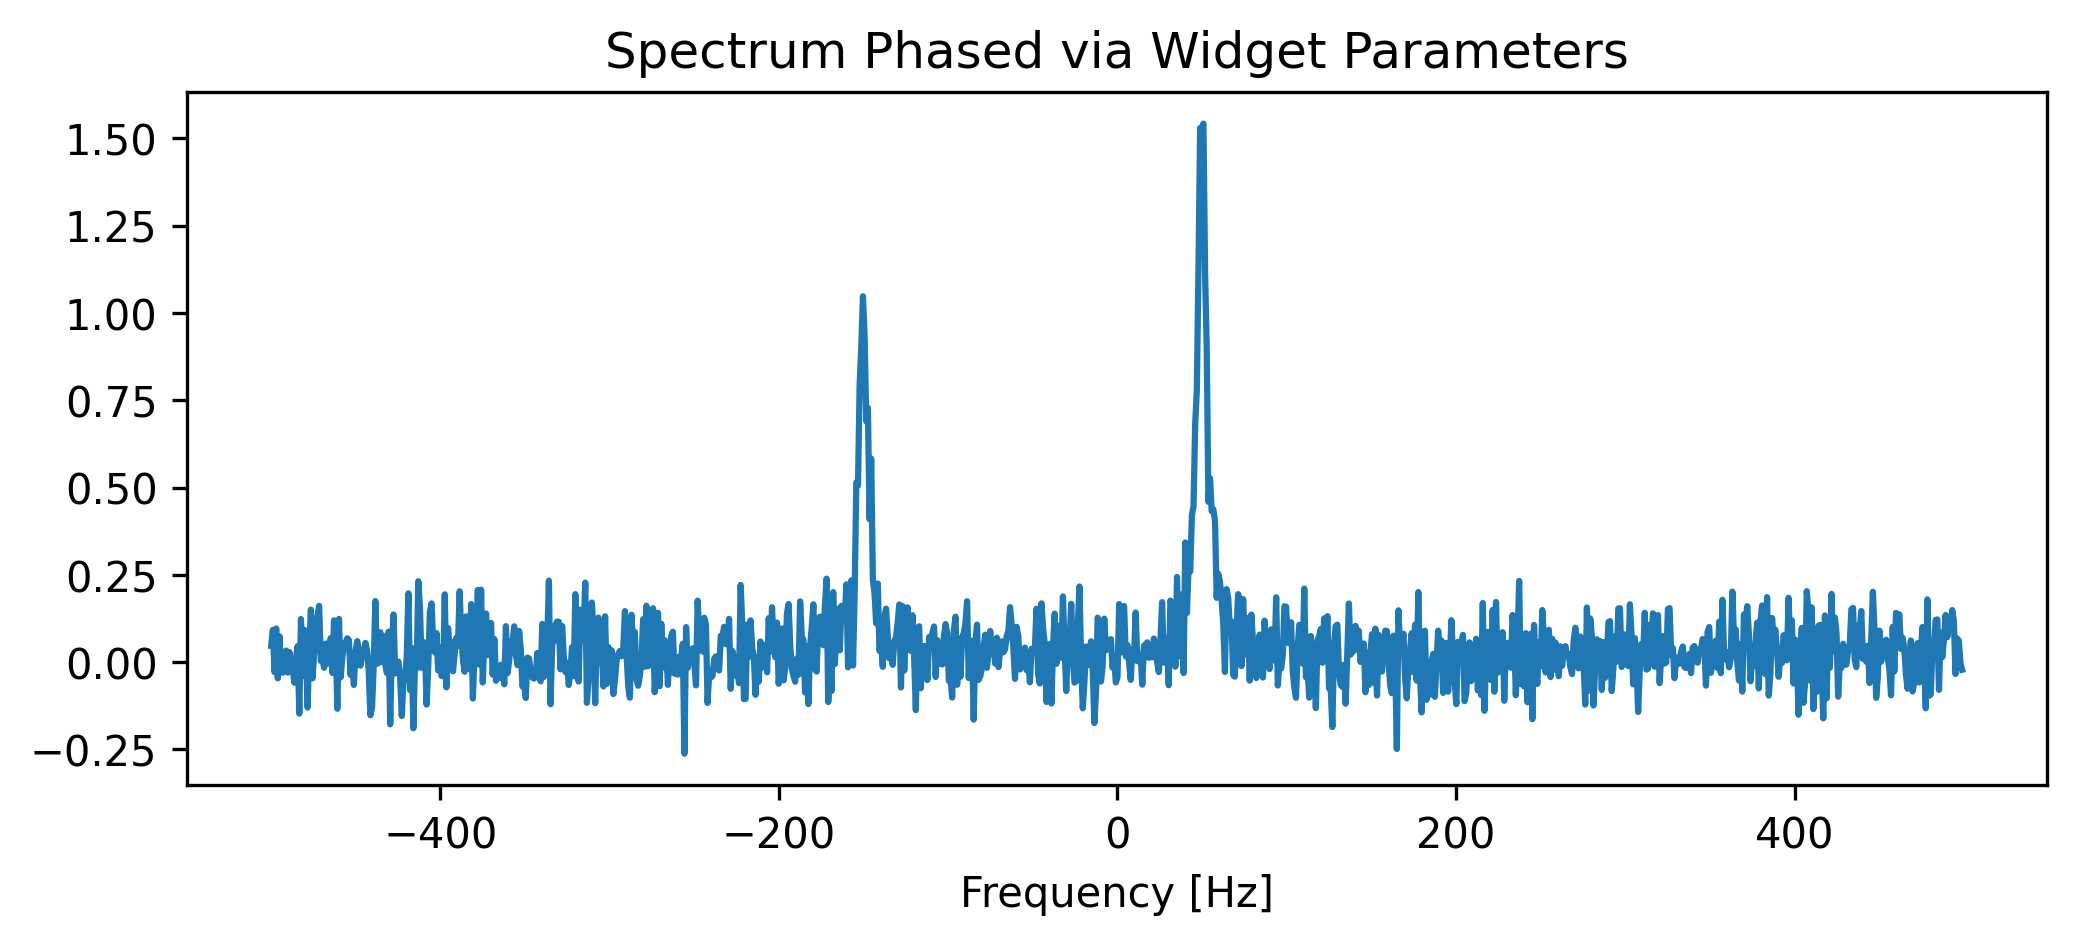

In [5]:
# This code is pasted directly from the widget's completion screen!
phased_da = da_ruined.xmr.phase(p0=-120.00, p1=45.00, pivot=50.000)

# Verify the correction
fig, ax = plt.subplots(figsize=(8, 3))
phased_da.real.plot(ax=ax, color="tab:blue")
plt.title("Spectrum Phased via Widget Parameters")
plt.show()

Because the `pivot` value is explicitly hardcoded into the generated snippet, your manual $p_1$ adjustment is guaranteed to produce the exact same mathematical output even if the array is later cropped, padded, or resampled!

In [6]:
# STRICT TESTS: Widget Output Integration
assert "phase_p0" in phased_da.attrs
assert "phase_p1" in phased_da.attrs
assert "phase_pivot" in phased_da.attrs

np.testing.assert_allclose(
    phased_da.values,
    da_spec.values,
    rtol=1e-3,
    atol=1e-3,
    err_msg="Widget phase parameters did not successfully invert the synthetic phase error.",
)